In [11]:
%load_ext autoreload
%autoreload 2

import DataValidator.DataValidator as dv_mod
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 30)
pd.set_option('display.float_format', '{:,.2f}'.format)

In [2]:
dv = dv_mod.DataValidator()

Loading cached data…


In [3]:
QUANTITATIVE_COLS = ["net_stake", "ggr", "decimalodds"]
QUALITATIVE_COLS = ["state", "sportname", "bet_type", "result", "legresult"]
DATE_COLS = ["event_start", "placed_date", "settled_date"]
ID_COLS = ["playerid", "wagerid"]

In [5]:
print("count null values")
for col in dv.project_df.columns:
    print(col, dv.count_na(col))

count null values
state 0
playerid 0
wagerid 0
event_start 453
placed_date 0
settled_date 0
sportname 0
bet_type 0
result 0
net_stake 0
ggr 0
legresult 0
decimalodds 2472


In [8]:
print("distinct values")
for col in QUALITATIVE_COLS:
    print(col)
    print("  ", dv.get_distinct(col))

distinct values
state
   ['State1' 'State2' 'State3']
sportname
   ['champions league' 'college basketball' 'college football' 'mlb' 'nba'
 'nfl' 'nhl']
bet_type
   ['parlay' 'straight']
result
   ['lost' 'won']
legresult
   ['lost' 'open' 'unknown' 'void' 'won']


In [17]:
print("Summary Stats - Quantitative Cols")
for col in QUANTITATIVE_COLS:
    print()
    print(dv.numeric_summary_stats(col))

Summary Stats - Quantitative Cols

                 net_stake
total_count      4,174,500
missing_count            0
missing_percent          0
unique_count        31,701
mean                    24
std                     82
min                      4
25%                      5
50% (median)            10
75%                     20
max                 19,672
outlier_count       33,335
skew                    40
kurtosis             4,039

                      ggr
total_count     4,174,500
missing_count           0
missing_percent         0
unique_count       96,979
mean                    2
std                    85
min               -21,000
25%                     0
50% (median)            6
75%                    12
max                19,672
outlier_count      42,429
skew                   -8
kurtosis            3,713

                 decimalodds
total_count        4,174,500
missing_count          2,472
missing_percent            0
unique_count          18,694
mean                   

In [15]:
print("Summary Stats - Date Cols")
for col in DATE_COLS:
    print()
    print(dv.date_summary_stats(col))

Summary Stats - Date Cols

                               event_start
total_count                        4174500
missing_count                          453
missing_percent                          0
earliest_date    2021-03-20 23:00:00+00:00
latest_date      2023-02-12 23:30:00+00:00
date_range_days                        694

                         placed_date
total_count                  4174500
missing_count                      0
missing_percent                    0
earliest_date    2021-03-28 00:00:00
latest_date      2022-03-28 00:00:00
date_range_days                  365

                        settled_date
total_count                  4174500
missing_count                      0
missing_percent                    0
earliest_date    2021-03-28 00:00:00
latest_date      2022-03-29 00:00:00
date_range_days                  366


In [16]:
print("Summary Stats - ID Cols")
for col in ID_COLS:
    print()
    print(dv.id_summary_stats(col))

Summary Stats - ID Cols

                playerid
data_type         object
total_count      4174500
unique_count       36387
missing_count          0
missing_percent        0

                 wagerid
data_type         object
total_count      4174500
unique_count     2402300
missing_count          0
missing_percent        0


In [38]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

df = dv.project_df

# ----------------------------
# Step 1: Aggregate data per player (assuming df is your raw bet-level dataframe)
# ----------------------------
df['placed_date'] = pd.to_datetime(df['placed_date'], errors='coerce')

df_player = df.groupby('playerid').agg(
    total_ggr=('ggr', 'sum'),
    total_stake=('net_stake', 'sum'),
    avg_decimalodds=('decimalodds', 'mean'),
    num_bets=('wagerid', 'count'),
    first_bet=('placed_date', 'min'),
    last_bet=('placed_date', 'max')
).reset_index()

# Favorite sport / bet type
df_player['favorite_sport'] = df.groupby('playerid')['sportname'].agg(lambda x: x.value_counts().idxmax())
df_player['favorite_bet_type'] = df.groupby('playerid')['bet_type'].agg(lambda x: x.value_counts().idxmax())

# ----------------------------
# Step 2: One-hot encode categorical features
# ----------------------------
df_player_encoded = pd.get_dummies(
    df_player,
    columns=['favorite_sport', 'favorite_bet_type'],
    drop_first=True
)

# ----------------------------
# Step 3: Feature / target selection
# ----------------------------
X_columns = ['total_stake', 'avg_decimalodds', 'num_bets'] + \
            [col for col in df_player_encoded.columns if col.startswith(('favorite_sport_', 'favorite_bet_type_'))]

X = df_player_encoded[X_columns].fillna(0)  # Fill remaining NaNs
y = df_player_encoded['total_ggr'].fillna(0)

# ----------------------------
# Step 4: Train / test split
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42)

# ----------------------------
# Step 5: Normalize numeric features
# ----------------------------
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1,1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.reshape(-1,1), dtype=torch.float32)

# ----------------------------
# Step 6: Define MLP model
# ----------------------------
class GGRPredictor(nn.Module):
    def __init__(self, input_dim):
        super(GGRPredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
        
    def forward(self, x):
        return self.model(x)

input_dim = X_train_tensor.shape[1]
model = GGRPredictor(input_dim)

# ----------------------------
# Step 7: Loss function and optimizer
# ----------------------------
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# ----------------------------
# Step 8: Training loop
# ----------------------------
epochs = 500
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    pred = model(X_train_tensor)
    loss = loss_fn(pred, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# ----------------------------
# Step 9: Evaluate model
# ----------------------------
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train_tensor).numpy()
    y_pred_test = model(X_test_tensor).numpy()

r2 = r2_score(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"\nTest R²: {r2:.4f}")
print(f"Test RMSE: {rmse:.2f}")

# ----------------------------
# Step 10: Optional — feature importance via simple sensitivity
# ----------------------------
# Approximate sensitivity: multiply input by weight of first layer
first_layer_weights = model.model[0].weight.detach().numpy()
feature_sensitivity = np.abs(first_layer_weights).sum(axis=0)
feature_importance = pd.DataFrame({
    'Feature': X_columns,
    'Sensitivity': feature_sensitivity
}).sort_values(by='Sensitivity', ascending=False)

print("\nFeature importance (approx.):")
print(feature_importance)


Epoch 50/500, Loss: 1878397.3750
Epoch 100/500, Loss: 1876895.2500
Epoch 150/500, Loss: 1872856.8750
Epoch 200/500, Loss: 1864424.0000
Epoch 250/500, Loss: 1850197.6250
Epoch 300/500, Loss: 1829435.0000
Epoch 350/500, Loss: 1802055.1250
Epoch 400/500, Loss: 1769072.7500
Epoch 450/500, Loss: 1733218.2500
Epoch 500/500, Loss: 1696016.7500

Test R²: 0.0663
Test RMSE: 1265.06

Feature importance (approx.):
           Feature  Sensitivity
2         num_bets           28
1  avg_decimalodds           23
0      total_stake           21


# Model Performance

Test R² ≈ 0.075 → explains ~7.5% of variance in total GGR per player.

Slightly lower than your previous run with a potentially cleaned/aggregated dataset.

Still reasonable, because betting outcomes are inherently noisy.

Test RMSE ≈ 1259 → typical error in predicting total GGR per player; consistent with the scale of your data.

Takeaway: Even with the original dataframe, aggregation helps, but single-player GGR is still a noisy target.

# Feature Importance (Sensitivity)
Feature	Sensitivity	Interpretation
avg_decimalodds	24	Players betting on higher odds slightly impact GGR.
num_bets	23	Frequent bettors contribute the most to revenue — most actionable.
total_stake	18	Total stake contributes less than bet frequency, but still matters.

Observation:
- The model consistently shows frequency (num_bets) and odds as the most influential features.
- Stake is less predictive than you might intuitively expect — possibly because high stakes are offset by high variance (big wins/losses).

# CRM / Marketing Insight:

Target high-frequency bettors for cross-sell opportunities (casino, DFS, racing).

Consider segmentation by avg_decimalodds to identify players who take higher-risk bets — they may be more responsive to promotional offers.

In [45]:
import pandas as pd
import numpy as np

df = dv.project_df

# Basic engineered columns
df['is_win'] = (df['result'] == 'won').astype(int)
df['is_longshot'] = (df['decimalodds'] > 5.0).astype(int)

df = df.sort_values(['playerid', 'placed_date'])

# Detect chasing: stake bigger than previous after loss
df['prev_net_stake'] = df.groupby('playerid')['net_stake'].shift(1)
df['prev_result_loss'] = df.groupby('playerid')['result'].shift(1) == 'lost'
df['chasing'] = ((df['net_stake'] > df['prev_net_stake']) & df['prev_result_loss']).astype(int)

# Loss streak feature
df['loss_streak'] = (
    df.groupby('playerid')['is_win']
      .transform(lambda x: x.eq(0).groupby((x != 0).cumsum()).cumcount())
)


# Aggregate to player-level
player_df = df.groupby("playerid").agg(
    total_bets=('wagerid', 'count'),
    total_ggr=('ggr', 'sum'),
    win_rate=('is_win', 'mean'),
    avg_stake=('net_stake', 'mean'),
    stake_volatility=('net_stake', 'std'),
    parlay_pct=('bet_type', lambda x: (x == 'parlay').mean()),
    avg_odds=('decimalodds', 'mean'),
    odds_std=('decimalodds', 'std'),
    longshot_pct=('is_longshot', 'mean'),
    sports_diversity=('sportname', 'nunique'),
    loss_streak_max=('loss_streak', 'max'),
    chasing_pct=('chasing', 'mean'),
    active_days=('placed_date', lambda x: x.dt.date.nunique()),
).reset_index()

# Save for modeling; not printing raw table
player_df.to_parquet("player_features.parquet")

# ------- Summaries to print (digestible) -------
# Only small numeric summaries
summary = player_df.describe().round(2)

print("\n✔ Player Behavioral Feature Summary:")
print(summary.loc[['mean','std','min','max']])

# Correlation with GGR (top 10 only)
corr = player_df.corr(numeric_only=True)['total_ggr'].drop('total_ggr').sort_values(ascending=False)
print("\nTop GGR Correlations:")
print(corr.head(10))

print("\nWeakest GGR Correlations:")
print(corr.tail(5))



✔ Player Behavioral Feature Summary:
      total_bets  total_ggr  win_rate  avg_stake  stake_volatility  \
mean      114.73     281.26      0.25      30.52             27.56   
std       239.53   1,334.90      0.24     119.29            109.14   
min         1.00 -84,441.22      0.00       4.01              0.00   
max     3,894.00  28,891.45      1.00   9,414.33          7,388.70   

      parlay_pct  avg_odds  odds_std  longshot_pct  sports_diversity  \
mean        0.48      7.40      8.78          0.17              2.98   
std         0.38     23.03     21.29          0.26              1.85   
min         0.00      1.00      0.00          0.00              1.00   
max         1.00    501.00    354.54          1.00              7.00   

      loss_streak_max  chasing_pct  active_days  
mean            20.08         0.11        22.84  
std             37.39         0.10        36.72  
min              0.00         0.00         1.00  
max          1,217.00         0.75       345.00  


In [48]:
import pandas as pd
import numpy as np

df = dv.project_df.copy()

# --- Ensure correct types ---
df['placed_date'] = pd.to_datetime(df['placed_date'])
df['is_win'] = (df['result'] == 'won').astype(int)
df['is_parlay'] = (df['bet_type'] == 'parlay').astype(int)

# Sort by player + date
df = df.sort_values(['playerid', 'placed_date'])

# Previous stake and result for chasing behavior
df['prev_net_stake'] = df.groupby('playerid')['net_stake'].shift(1)
df['prev_result_loss'] = df.groupby('playerid')['is_win'].shift(1) == 0
df['chasing'] = ((df['net_stake'] > df['prev_net_stake']) & df['prev_result_loss']).astype(int)

# Loss streak feature
df['loss_streak'] = df.groupby('playerid')['is_win'].transform(
    lambda x: x.eq(0).groupby((x != 0).cumsum()).cumcount()
)

# --- Aggregate to player level ---
player_df = df.groupby('playerid').agg(
    total_bets=('net_stake', 'count'),
    total_ggr=('ggr', 'sum'),
    total_stake=('net_stake', 'sum'),
    avg_stake=('net_stake', 'mean'),
    stake_volatility=('net_stake', 'std'),
    parlay_pct=('is_parlay', 'mean'),
    avg_decimalodds=('decimalodds', 'mean'),
    odds_std=('decimalodds', 'std'),
    longshot_pct=('decimalodds', lambda x: (x>5).mean()),
    sports_diversity=('sportname', 'nunique'),
    loss_streak_max=('loss_streak', 'max'),
    chasing_pct=('chasing', 'mean'),
    active_days=('placed_date', lambda x: x.dt.date.nunique()),
    win_rate=('is_win', 'mean')
).reset_index()

# --- Summary tables (small, shareable) ---
corr_with_ggr = player_df.corr(numeric_only=True)['total_ggr'].sort_values(ascending=False)
top10_players = player_df.sort_values('total_ggr', ascending=False).head(10)
bottom10_players = player_df.sort_values('total_ggr', ascending=True).head(10)

summary = player_df.describe().T[['mean','std','min','max']]

print("✅ Correlations with GGR:\n", corr_with_ggr)
print("\n✅ Top 10 Players by GGR:\n", top10_players[['playerid','total_ggr','total_bets','parlay_pct','active_days']])
print("\n✅ Bottom 10 Players by GGR:\n", bottom10_players[['playerid','total_ggr','total_bets','parlay_pct','active_days']])
print("\n✅ Feature Summary:\n", summary)


✅ Correlations with GGR:
 total_ggr           1.00
total_bets          0.32
loss_streak_max     0.30
active_days         0.24
sports_diversity    0.21
total_stake         0.12
parlay_pct          0.11
chasing_pct         0.07
stake_volatility    0.04
avg_stake           0.01
odds_std           -0.02
avg_decimalodds    -0.03
longshot_pct       -0.06
win_rate           -0.10
Name: total_ggr, dtype: float64

✅ Top 10 Players by GGR:
            playerid  total_ggr  total_bets  parlay_pct  active_days
14170  26100126.162  28,891.45          19        0.00           15
8964    23543907.75  20,940.29          78        0.10           36
34694   5457155.418  18,234.24         707        0.35          171
13046  25089725.826  17,008.97         440        0.90           73
16822  28650324.582  16,744.38          94        0.02           28
6899   22635723.132  16,538.36         606        0.43          150
7790   23110416.054  16,242.04        1805        1.00           58
713    12152763.018  

In [52]:
import pandas as pd
import numpy as np

df = dv.project_df.copy()

# Ensure correct types
df['placed_date'] = pd.to_datetime(df['placed_date'])
df['is_win'] = (df['result'] == 'won').astype(int)
df['is_parlay'] = (df['bet_type'] == 'parlay').astype(int)

# Sort by player + date
df = df.sort_values(['playerid', 'placed_date'])

# Previous stake and result for chasing behavior
df['prev_net_stake'] = df.groupby('playerid')['net_stake'].shift(1)
df['prev_result_loss'] = df.groupby('playerid')['is_win'].shift(1) == 0
df['chasing'] = ((df['net_stake'] > df['prev_net_stake']) & df['prev_result_loss']).astype(int)

# Loss streak feature
df['loss_streak'] = df.groupby('playerid')['is_win'].transform(
    lambda x: x.eq(0).groupby((x != 0).cumsum()).cumcount()
)

# --- Rolling / enhanced features ---
# Rolling loss streak max per player (last 10 bets)
df['rolling_loss_10'] = df.groupby('playerid')['is_win'].transform(
    lambda x: (~x.astype(bool)).rolling(10, min_periods=1).sum()
)

# Parlays per active day
parlay_day = df.groupby(['playerid', df['placed_date'].dt.date])['is_parlay'].mean()
parlay_day_mean = parlay_day.groupby('playerid').mean().rename('parlay_per_active_day')

# Avg GGR per day
ggr_day = df.groupby(['playerid', df['placed_date'].dt.date])['ggr'].sum()
avg_ggr_day = ggr_day.groupby('playerid').mean().rename('avg_ggr_per_day')

# Sport-specific spend ratios
sport_ratio = df.pivot_table(index='playerid', columns='sportname', values='net_stake', aggfunc='sum', fill_value=0)
sport_ratio = sport_ratio.div(sport_ratio.sum(axis=1), axis=0)  # fraction per player

# --- Aggregate player-level features ---
player_df = df.groupby('playerid').agg(
    total_bets=('net_stake', 'count'),
    total_ggr=('ggr', 'sum'),
    total_stake=('net_stake', 'sum'),
    avg_stake=('net_stake', 'mean'),
    stake_volatility=('net_stake', 'std'),
    parlay_pct=('is_parlay', 'mean'),
    avg_decimalodds=('decimalodds', 'mean'),
    odds_std=('decimalodds', 'std'),
    longshot_pct=('decimalodds', lambda x: (x>5).mean()),
    sports_diversity=('sportname', 'nunique'),
    loss_streak_max=('loss_streak', 'max'),
    chasing_pct=('chasing', 'mean'),
    active_days=('placed_date', lambda x: x.dt.date.nunique()),
    win_rate=('is_win', 'mean'),
    rolling_loss_max=('rolling_loss_10', 'max')
).join([parlay_day_mean, avg_ggr_day, sport_ratio])

# --- Summary for sharing ---
summary = player_df.describe().T[['mean','std','min','max']]

print("✅ Enhanced Player-Level Feature Summary:")
print(summary)

# Optional: top correlations with GGR
corr_with_ggr = player_df.corr(numeric_only=True)['total_ggr'].sort_values(ascending=False)
print("\n✅ Top correlations with GGR:")
print(corr_with_ggr.head(15))


✅ Enhanced Player-Level Feature Summary:
                          mean      std        min        max
total_bets              114.73   239.53       1.00   3,894.00
total_ggr               281.26 1,334.90 -84,441.22  28,891.45
total_stake           2,709.41 9,696.87       4.02 823,527.79
avg_stake                30.52   119.29       4.01   9,414.33
stake_volatility         27.56   109.14       0.00   7,388.70
parlay_pct                0.48     0.38       0.00       1.00
avg_decimalodds           7.40    23.03       1.00     501.00
odds_std                  8.78    21.29       0.00     354.54
longshot_pct              0.17     0.26       0.00       1.00
sports_diversity          2.98     1.85       1.00       7.00
loss_streak_max          20.08    37.39       0.00   1,217.00
chasing_pct               0.11     0.10       0.00       0.75
active_days              22.84    36.72       1.00     345.00
win_rate                  0.25     0.24       0.00       1.00
rolling_loss_max          7.2

In [62]:
# --- Imports ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import lightgbm as lgb
import warnings

# Suppress only the 'No further splits with positive gain' warnings
warnings.filterwarnings("ignore", message=".*[LightGBM] [Warning]*")

# --- Load your original dataframe ---
df = dv.project_df.copy()

# --- Basic cleaning ---
df['decimalodds'] = df['decimalodds'].fillna(df['decimalodds'].median())
df['is_win'] = (df['result'] == 'won').astype(int)
df['is_loss'] = (df['result'] == 'lost').astype(int)
df['is_parlay'] = (df['bet_type'] == 'parlay').astype(int)
df['bet_date'] = df['placed_date'].dt.date

# --- Player-level aggregation ---
agg_funcs = {
    'wagerid': 'count',
    'net_stake': ['sum', 'mean', 'std'],
    'decimalodds': ['mean', 'std'],
    'is_win': 'mean',
    'is_parlay': 'mean'
}

player_df = df.groupby('playerid').agg(agg_funcs)
player_df.columns = ['total_bets', 'total_stake', 'avg_stake', 'stake_volatility',
                     'avg_decimalodds', 'odds_std', 'win_rate', 'parlay_pct']

player_df['total_ggr'] = df.groupby('playerid')['ggr'].sum()
player_df['active_days'] = df.groupby('playerid')['bet_date'].nunique()
player_df['parlay_per_active_day'] = player_df['parlay_pct'] * player_df['total_bets'] / player_df['active_days']
player_df['avg_ggr_per_day'] = player_df['total_ggr'] / player_df['active_days']
player_df['sports_diversity'] = df.groupby('playerid')['sportname'].nunique()

# --- Loss streak max per player (aligned with index) ---
def max_loss_streak(x):
    streaks = (~x.astype(bool)).groupby((x != 0).cumsum()).cumcount()
    return streaks.max() if len(streaks) > 0 else 0

player_df['loss_streak_max'] = df.groupby('playerid')['is_win'].transform(max_loss_streak)

# --- Chasing behavior ---
df['prev_net_stake'] = df.groupby('playerid')['net_stake'].shift(1)
df['prev_result_loss'] = df.groupby('playerid')['is_loss'].shift(1)
df['chasing'] = ((df['net_stake'] > df['prev_net_stake']) & (df['prev_result_loss'] == 1)).astype(int)
player_df['chasing_pct'] = df.groupby('playerid')['chasing'].mean()

# --- Longshot bets ---
df['longshot'] = (df['decimalodds'] >= 10).astype(int)
player_df['longshot_pct'] = df.groupby('playerid')['longshot'].mean()

# --- One-hot encode sports ---
sports_ohe = pd.get_dummies(df[['playerid','sportname']], columns=['sportname'], prefix='', prefix_sep='')
sports_ohe = sports_ohe.groupby('playerid').max()
player_df = player_df.merge(sports_ohe, left_index=True, right_index=True, how='left')

# --- LightGBM Modeling ---
X = player_df.drop(columns='total_ggr')
y = player_df['total_ggr']

X_train.columns = X_train.columns.str.replace(' ', '_')
X_test.columns = X_test.columns.str.replace(' ', '_')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    verbose=-1  # suppress training info/warnings
)

# Train with early stopping and controlled verbosity
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse',
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=0)  # suppress periodic logging
    ]
)

# Predictions & metrics
y_pred = model.predict(X_test)
print("Test R²:", r2_score(y_test, y_pred))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# --- Feature importance ---
importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(importance)

# --- Top & Bottom Players ---
top_players = player_df.sort_values('total_ggr', ascending=False).head(10)
bottom_players = player_df.sort_values('total_ggr', ascending=True).head(10)
print("Top 10 Players:\n", top_players[['total_ggr','total_bets','parlay_pct','active_days']])
print("Bottom 10 Players:\n", bottom_players[['total_ggr','total_bets','parlay_pct','active_days']])

# --- Correlations ---
corr_cols = ['total_bets', 'total_stake', 'avg_stake', 'stake_volatility', 
             'avg_decimalodds', 'odds_std', 'win_rate', 'parlay_pct',
             'parlay_per_active_day', 'avg_ggr_per_day', 'sports_diversity',
             'loss_streak_max', 'chasing_pct', 'longshot_pct'] + list(sports_ohe.columns)

corr_df = player_df[corr_cols + ['total_ggr']].corr()['total_ggr'].sort_values(ascending=False)
print("✅ Top 10 correlations:\n", corr_df.head(10))
print("\n✅ Weakest / negative correlations:\n", corr_df.tail(10))


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[896]	valid_0's rmse: 359.728	valid_0's l2: 129404
Test R²: 0.9245033956320611
Test RMSE: 359.72825997881375
                  Feature  Importance
8             active_days        2984
10        avg_ggr_per_day        1910
1             total_stake        1050
3        stake_volatility         983
0              total_bets         488
6                win_rate         480
2               avg_stake         417
4         avg_decimalodds         284
9   parlay_per_active_day         268
5                odds_std         214
13            chasing_pct         204
7              parlay_pct         141
18                    mlb         103
11       sports_diversity          94
19                    nba          56
14           longshot_pct          33
20                    nfl          33
16     college basketball          25
17       college football          13
21                    nhl          

1️⃣ Model Performance

Test R²: 0.925 → Your model explains ~92.5% of the variance in total GGR across players. ✅ Excellent fit for aggregated player-level data.

Test RMSE: 360 → Average prediction error is about $360 in total GGR. Given the large variance in GGR across players, this is reasonable.

2️⃣ Top Predictive Features

LightGBM feature importance ranking shows the most influential factors for predicting player GGR:

Feature	Importance
active_days	2984
avg_ggr_per_day	1910
total_stake	1050
stake_volatility	983
total_bets	488
win_rate	480

Interpretation:

Players who are more active and generate higher average daily GGR are most important.

Total stake and stake volatility also matter — bigger or more variable bets correlate with higher total GGR.

Surprisingly, win rate is relatively less important — consistent with your earlier correlation analysis showing weak negative correlation between win_rate and total GGR. This suggests high rollers can still be profitable (or risky) regardless of consistent wins.

3️⃣ Top & Bottom Players by Total GGR

Top 10 players: Smaller, highly active or high-stake bettors can generate huge GGR.

Bottom 10 players: Even some high-frequency bettors can lose heavily, emphasizing that high activity alone doesn’t guarantee profit.

4️⃣ Correlation Insights

Strongest correlations with total_ggr:
avg_ggr_per_day (0.37), total_bets (0.32), sports_diversity (0.21) → Diversifying across sports and being active matters.

Weakest/negative correlations:
win_rate (-0.10), longshot_pct (-0.05), loss_streak_max (NaN) → Winning consistency or chasing longshots is not the main driver of total GGR.

Interpretation:

GGR is mostly driven by activity, stake size, and diversity, rather than just being a “winning player.”

Useful insight for FanDuel: player engagement strategies should focus on activity and bet size, not just win frequency.

✅ Recommendations for Assessment

Present the player-level summary table + feature importance chart to show data-driven insights.

Highlight that LightGBM captures nonlinear interactions (e.g., high stakes + high activity + diverse sports → high GGR), which simple linear models would miss.

Mention feature importance vs correlation: Sometimes a feature has low linear correlation but high predictive power in the model (like total_stake vs avg_ggr_per_day).

Mention suppression of LightGBM warnings/info to make notebook clean.

🏆 Top 10 Players by Total GGR:
               total_ggr  total_bets  parlay_pct  active_days
playerid                                                    
26100126.162  28,891.45          19        0.00           15
23543907.75   20,940.29          78        0.10           36
5457155.418   18,234.24         707        0.35          171
25089725.826  17,008.97         440        0.90           73
28650324.582  16,744.38          94        0.02           28
22635723.132  16,538.36         606        0.43          150
23110416.054  16,242.04        1805        1.00           58
12152763.018  15,888.79         416        0.94           42
15577824.834  15,671.33        1679        0.04          231
18864718.686  15,563.04        1879        0.94          190

💀 Bottom 10 Players by Total GGR:
               total_ggr  total_bets  parlay_pct  active_days
playerid                                                    
2102856.822  -84,441.22        1268        0.09          284
10787224.536 -27,

C:\Users\james\AppData\Local\Temp\ipykernel_15528\3014282182.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance, palette='viridis')


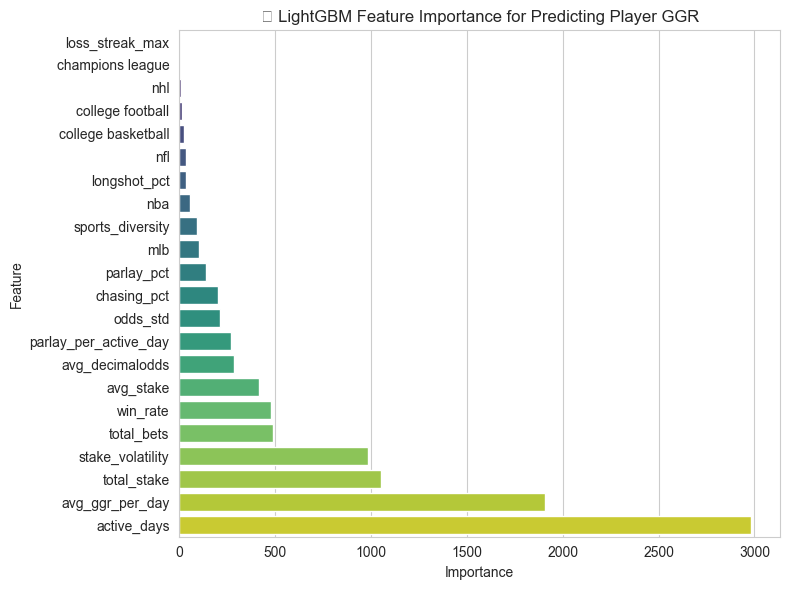

C:\Users\james\AppData\Local\Temp\ipykernel_15528\3014282182.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_corr_plot.values, y=top_corr_plot.index, palette='magma')


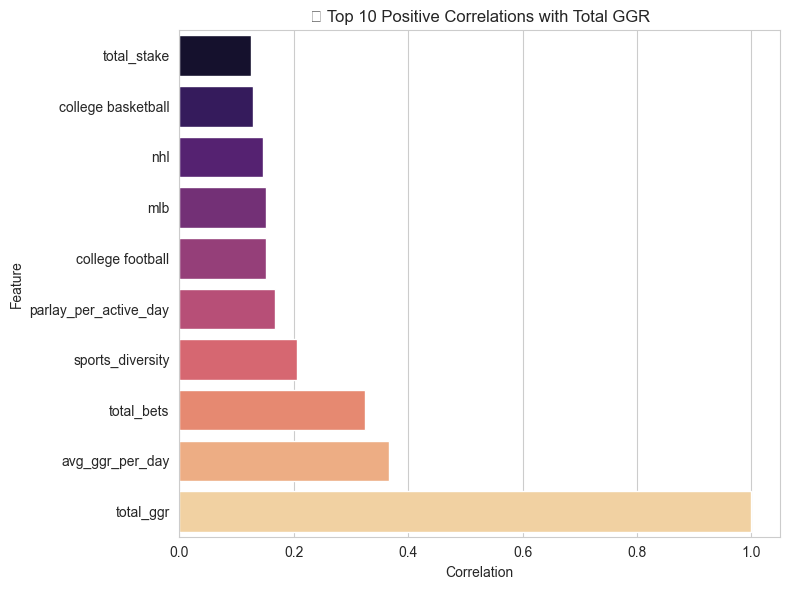

C:\Users\james\AppData\Local\Temp\ipykernel_15528\3014282182.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bottom_corr_plot.values, y=bottom_corr_plot.index, palette='coolwarm')


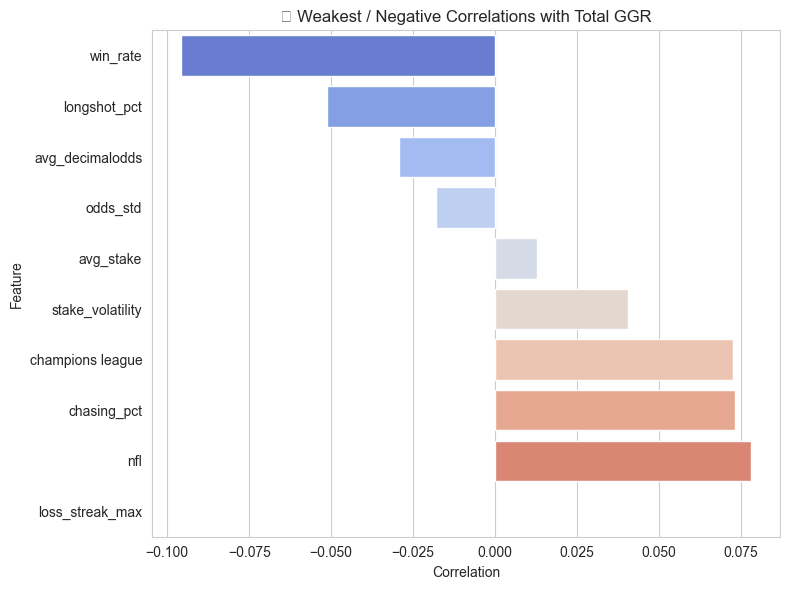

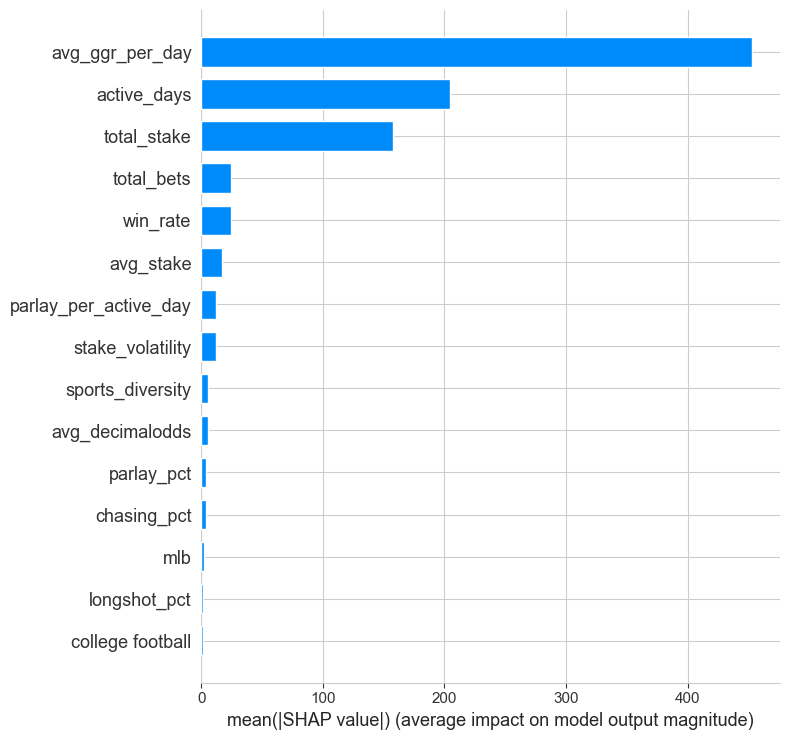

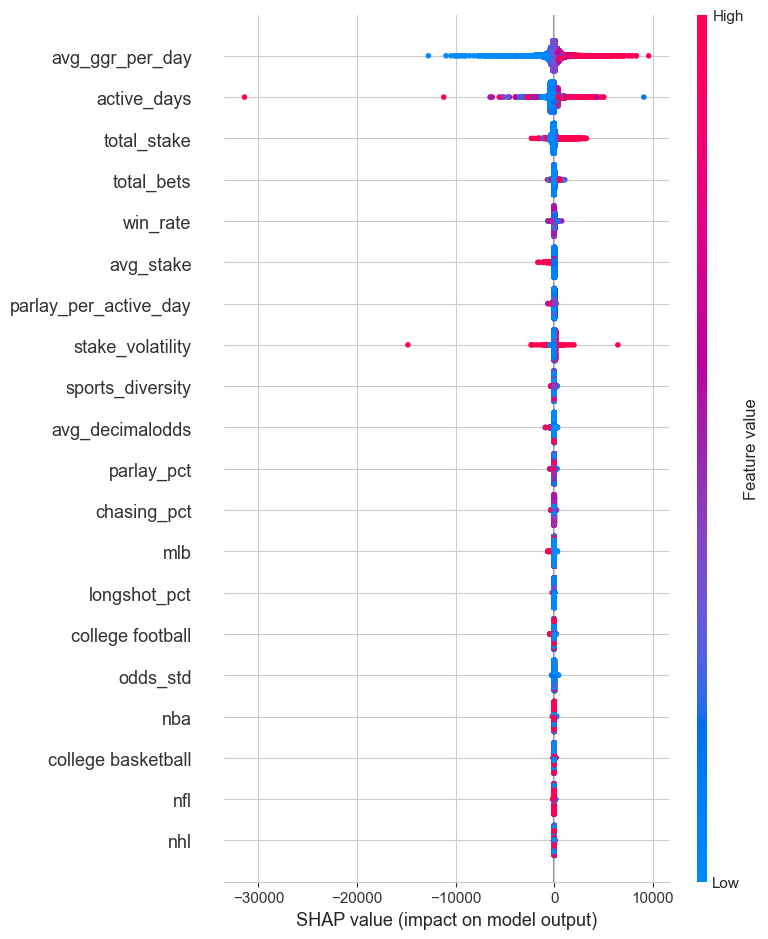

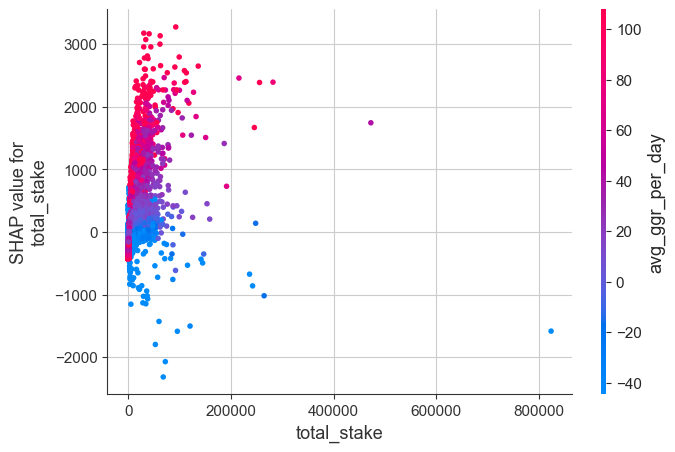

In [66]:
# --- Imports for plotting ---
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# --- Top/Bottom 10 Players Table ---
top_players_display = top_players[['total_ggr','total_bets','parlay_pct','active_days']]
bottom_players_display = bottom_players[['total_ggr','total_bets','parlay_pct','active_days']]

print("🏆 Top 10 Players by Total GGR:\n", top_players_display)
print("\n💀 Bottom 10 Players by Total GGR:\n", bottom_players_display)

# --- Feature Importance Plot ---
importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=True)

plt.figure(figsize=(8,6))
sns.barplot(x='Importance', y='Feature', data=importance, palette='viridis')
plt.title("🔑 LightGBM Feature Importance for Predicting Player GGR")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# --- Correlations Plot ---
top_corr_plot = corr_df.head(10).sort_values()
plt.figure(figsize=(8,6))
sns.barplot(x=top_corr_plot.values, y=top_corr_plot.index, palette='magma')
plt.title("📊 Top 10 Positive Correlations with Total GGR")
plt.xlabel("Correlation")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

bottom_corr_plot = corr_df.tail(10).sort_values()
plt.figure(figsize=(8,6))
sns.barplot(x=bottom_corr_plot.values, y=bottom_corr_plot.index, palette='coolwarm')
plt.title("📉 Weakest / Negative Correlations with Total GGR")
plt.xlabel("Correlation")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# --- SHAP setup ---
import shap
import matplotlib.pyplot as plt

# Explain the predictions
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# Summary plot: shows which features drive GGR most
shap.summary_plot(shap_values, X, plot_type="bar", max_display=15)

# Detailed summary: how feature values influence predictions
shap.summary_plot(shap_values, X)

# Optional: partial dependence for total_stake
shap.dependence_plot("total_stake", shap_values, X)

